In [ ]:
%pip install pandas scikit-learn xgboost matplotlib seaborn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   --- ------------------------------------ 0.8/8.1 MB 4.7 MB/s eta 0:00:02
   --------- ------------------------------ 1.8/8.1 MB 5.0 MB/s eta 0:00:02
   -------------- ------------------------- 2.9/8.1 MB 5.1 MB/s eta 0:00:02
   -------------------- ------------------- 4.2/8.1 MB 5.4 MB/s eta 0:00:01
   --------------------------- ------------ 5.5/8.1 MB 5.6 MB/s eta 0:00:01
   ----------------------------------- ---- 7.1/8.1 MB 5.9 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 5.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------- ----------- 1.6/2.2 MB 8.1 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 7.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   --------- ------------------

Datos de la competencia

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c udea-ai-4-eng-20251-pruebas-saber-pro-colombia
!unzip -l udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip
!unzip udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip

Carga de datos

In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (692500, 21)
Test shape: (296786, 20)


Limpieza

In [ ]:
X = train_df.drop(columns=["RENDIMIENTO_GLOBAL"])
y = train_df["RENDIMIENTO_GLOBAL"]

print(f"Clases únicas en y: {y.unique()}")
print(f"Distribución de clases:")
print(y.value_counts())

# Codificar la variable objetivo
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print(f"\nClases codificadas: {label_encoder.classes_}")
print(f"Mapeo: {dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))}")

# Detectar columnas categóricas
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"\nColumnas categóricas: {categorical_features}")

# Limpiar NaN categóricas
for col in categorical_features:
    X[col] = X[col].fillna("Unknown")

# Limpiar NaN numéricas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
for col in numeric_features:
    X[col] = X[col].fillna(X[col].median())

# Aplicar one-hot encoding a las categóricas
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)
print(f"\nShape después de encoding: {X_encoded.shape}")

# Obtener índices categóricos (ya no necesarios con one-hot encoding)
# categorical_indices = [X.columns.get_loc(col) for col in categorical_features]


Clases únicas en y: ['medio-alto' 'bajo' 'alto' 'medio-bajo']
Distribución de clases:
RENDIMIENTO_GLOBAL
alto          175619
bajo          172987
medio-bajo    172275
medio-alto    171619
Name: count, dtype: int64

Clases codificadas: ['alto' 'bajo' 'medio-alto' 'medio-bajo']
Mapeo: {0: 'alto', 1: 'bajo', 2: 'medio-alto', 3: 'medio-bajo'}

Columnas categóricas: ['ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_DEPARTAMENTO', 'ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA', 'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEINTERNET', 'FAMI_EDUCACIONPADRE', 'FAMI_TIENELAVADORA', 'FAMI_TIENEAUTOMOVIL', 'ESTU_PRIVADO_LIBERTAD', 'ESTU_PAGOMATRICULAPROPIO', 'FAMI_TIENECOMPUTADOR', 'FAMI_TIENEINTERNET.1', 'FAMI_EDUCACIONMADRE']

Shape después de encoding: (692500, 1040)

Shape después de encoding: (692500, 1040)


Entrenamiento

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"Clases en y_train: {np.unique(y_train)}")

model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(label_encoder.classes_),  # Usar el número real de clases
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    n_estimators=100,  # Reducir para evitar problemas de memoria
    max_depth=6
)

print("Entrenando modelo...")
model.fit(X_train, y_train)
print("✅ Modelo entrenado correctamente")

X_train shape: (554000, 1040)
y_train shape: (554000,)
Clases en y_train: [0 1 2 3]
Entrenando modelo...


C:\Users\Usuario\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [21:50:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Modelo entrenado correctamente


Evaluación del modelo


Accuracy en validación: 0.4287292418772563

REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

        alto       0.54      0.62      0.57     35124
        bajo       0.46      0.56      0.50     34597
  medio-alto       0.33      0.25      0.28     34324
  medio-bajo       0.33      0.28      0.31     34455

    accuracy                           0.43    138500
   macro avg       0.41      0.43      0.42    138500
weighted avg       0.41      0.43      0.42    138500

              precision    recall  f1-score   support

        alto       0.54      0.62      0.57     35124
        bajo       0.46      0.56      0.50     34597
  medio-alto       0.33      0.25      0.28     34324
  medio-bajo       0.33      0.28      0.31     34455

    accuracy                           0.43    138500
   macro avg       0.41      0.43      0.42    138500
weighted avg       0.41      0.43      0.42    138500



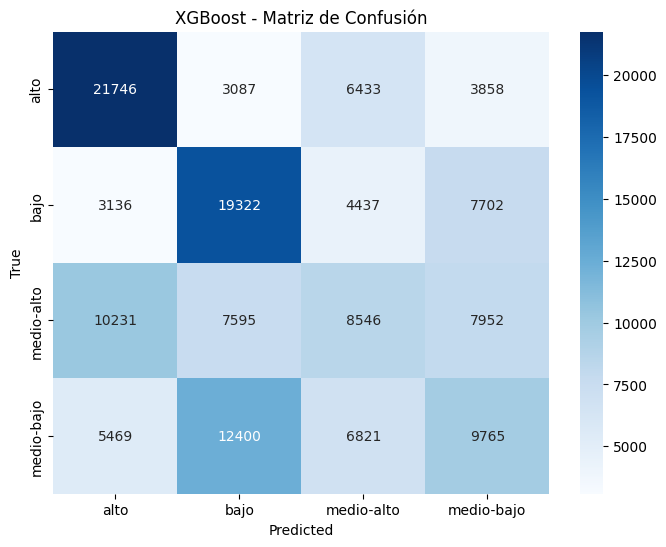

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_val)

# Convertir predicciones de vuelta a labels originales para mostrar
y_val_labels = label_encoder.inverse_transform(y_val)
y_pred_labels = label_encoder.inverse_transform(y_pred)

print("\nAccuracy en validación:", accuracy_score(y_val, y_pred))
print("\nREPORTE DE CLASIFICACIÓN:")
print(classification_report(y_val_labels, y_pred_labels))

# Matriz de confusión con labels originales
cm = confusion_matrix(y_val_labels, y_pred_labels, labels=label_encoder.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title("XGBoost - Matriz de Confusión")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Test y submisión

In [ ]:
X_test = test_df.drop(columns=['RENDIMIENTO_GLOBAL'], errors='ignore')

# Aplicar el mismo preprocesamiento que al train
for col in categorical_features:
    if col in X_test.columns:
        X_test[col] = X_test[col].fillna("Unknown")
        
for col in numeric_features:
    if col in X_test.columns:
        X_test[col] = X_test[col].fillna(X[col].median())

# Aplicar one-hot encoding
X_test_encoded = pd.get_dummies(X_test, columns=categorical_features, drop_first=True)

# Asegurar que test tenga las mismas columnas que train
X_test_encoded = X_test_encoded.reindex(columns=X_encoded.columns, fill_value=0)

print(f"X_test_encoded shape: {X_test_encoded.shape}")
print(f"X_train shape: {X_encoded.shape}")

print("\nGenerando predicciones sobre test...")
test_pred_encoded = model.predict(X_test_encoded)

# Convertir predicciones de vuelta a labels originales
test_pred = label_encoder.inverse_transform(test_pred_encoded)

# Detección de columna ID
test_id_col = None
for possible_id in ["ID", "id", "index", "row_id"]:
    if possible_id in test_df.columns:
        test_id_col = possible_id
        break

if test_id_col is None:
    print("⚠ No se encontró columna ID, generando índices como ID")
    test_ids = range(len(test_pred))
    test_id_col = "ID"
else:
    test_ids = test_df[test_id_col]

submission = pd.DataFrame({
    test_id_col: test_ids,
    "RENDIMIENTO_GLOBAL": test_pred
})

print(f"\nDistribución de predicciones:")
print(pd.Series(test_pred).value_counts())

submission.to_csv("submission.csv", index=False)
print(f"\n✅ 'submission.csv' generado correctamente con {submission.shape[0]} filas")
print(f"Archivo guardado en: {os.path.abspath('submission.csv')}")

X_test_encoded shape: (296786, 1040)
X_train shape: (692500, 1040)

Generando predicciones sobre test...

Distribución de predicciones:
bajo          91851
alto          86281
medio-bajo    61589
medio-alto    57065
Name: count, dtype: int64

Distribución de predicciones:
bajo          91851
alto          86281
medio-bajo    61589
medio-alto    57065
Name: count, dtype: int64

✅ 'submission.csv' generado correctamente con 296786 filas
Archivo guardado en: c:\Users\Usuario\Downloads\submission.csv

✅ 'submission.csv' generado correctamente con 296786 filas
Archivo guardado en: c:\Users\Usuario\Downloads\submission.csv
